In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import copy as cp
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, cross_val_predict 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix, accuracy_score

from typing import Tuple

In [2]:
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_row", 160)
pd.set_option('max_colwidth', 200)

In [3]:
data = pd.read_csv('../../Data/20x43_DEFG86017_5.csv')
data.head(5)

,loan_amnt,annual_inc,dti,fico_range_low,fico_range_high,int_rate,installment,open_acc,total_acc,revol_bal,inq_last_6mths,delinq_2yrs,mths_since_last_delinq,acc_now_delinq,collections_12_mths_ex_med,pub_rec,months_cr_line,term,initial_list_status,grade,sub_grade,emp_length,ANY,MORTGAGE,OWN,RENT,car,credit_card,debt_consolidation,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,wedding,Not Verified,Source Verified,Verified,loan_status_bin
0,-0.394780,-0.092019,-0.873321,1.940594,1.940594,-0.583950,-0.393509,-0.321346,-0.841857,-0.819426,1.187098,0.393653,-0.313130,-0.069643,-0.151296,-0.426999,-0.884191,-0.239876,1.395799,-0.043589,0.530201,-0.529283,-0.029637,-0.791641,-0.356514,0.997808,-0.13366,-0.217565,-0.712232,3.435603,-0.148233,-0.194412,-0.235757,-0.226273,-0.590356,-0.069643,-0.243941,-0.193193,-0.089225,-0.627602,1.248119,-0.696197,0.0
1,-0.742344,-0.248924,0.844724,0.113283,0.113283,0.615513,-0.670219,-0.723183,-0.928005,-0.652416,0.423724,-0.463210,-0.900363,-0.069643,-0.151296,-0.426999,0.311603,-0.239876,1.395799,1.317237,1.486158,-1.592515,-0.029637,1.263199,-0.356514,-1.002196,-0.13366,-0.217565,1.404036,-0.291070,-0.148233,-0.194412,-0.235757,-0.226273,-0.590356,-0.069643,-0.243941,-0.193193,-0.089225,-0.627602,1.248119,-0.696197,0.0
2,0.689619,-0.078375,1.560036,-0.669850,-0.669850,-0.583950,0.680086,0.281409,0.967242,-0.116192,2.713845,2.964244,-0.900363,-0.069643,-0.151296,0.873978,-0.359506,-0.239876,1.395799,-0.043589,0.530201,-0.529283,-0.029637,1.263199,-0.356514,-1.002196,-0.13366,-0.217565,-0.712232,-0.291070,-0.148233,-0.194412,-0.235757,-0.226273,-0.590356,-0.069643,4.099352,-0.193193,-0.089225,-0.627602,1.248119,-0.696197,1.0
3,-0.241852,-0.221636,1.050025,-0.930894,-0.930894,1.406463,-0.098216,-0.321346,-0.411119,-0.611183,2.713845,0.393653,0.319274,-0.069643,-0.151296,0.873978,-0.566939,-0.239876,1.395799,1.317237,2.123462,0.002333,-0.029637,1.263199,-0.356514,-1.002196,-0.13366,-0.217565,1.404036,-0.291070,-0.148233,-0.194412,-0.235757,-0.226273,-0.590356,-0.069643,-0.243941,-0.193193,-0.089225,-0.627602,1.248119,-0.696197,1.0
4,0.773034,-0.207992,1.454144,-0.147761,-0.147761,-1.009846,0.719284,0.281409,-0.066529,0.231414,-0.339649,-0.463210,-0.900363,-0.069643,-0.151296,0.873978,1.165741,-0.239876,1.395799,-0.043589,0.211549,1.065565,-0.029637,1.263199,-0.356514,-1.002196,-0.13366,-0.217565,-0.712232,3.435603,-0.148233,-0.194412,-0.235757,-0.226273,-0.590356,-0.069643,-0.243941,-0.193193,-0.089225,-0.627602,-0.801206,1.436375,1.0


In [4]:
data.shape

(2279, 43)

In [5]:
data.loan_status_bin.value_counts()
#0 = Defaulted Loans
#1 = Loans Paid In Full

1.0    1786
0.0     493
Name: loan_status_bin, dtype: int64

In [6]:
X = data.drop('loan_status_bin', axis=1)
X.shape

(2279, 42)

In [7]:
y = data['loan_status_bin']

In [8]:
lr1 = LogisticRegression()

In [9]:
steps = [('model', lr1)]
pipeline = Pipeline(steps=steps)

In [10]:
#Accuracy:

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1) 
print(scores)

score = np.mean(scores)
print(score)

[0.77631579 0.77192982 0.7872807  0.78070175 0.77362637]
0.7779708887603624


In [11]:
#Aggregated Confusion Matrix From RepeatedStratifiedKFold: 
y_pred = cross_val_predict(pipeline, X, y, cv=cv, n_jobs=-1)
conf_mat = confusion_matrix(y, y_pred)
conf_mat

array([[  15,  478],
       [  28, 1758]])

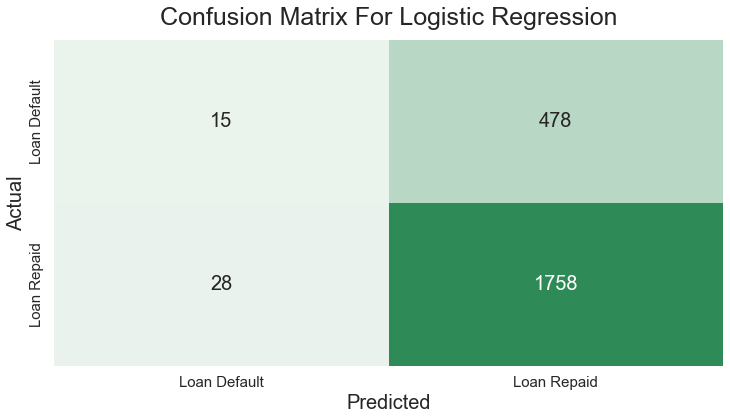

In [12]:
sns.set(rc = {'figure.figsize':(12,6)})
#cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
cmap = sns.light_palette('seagreen', as_cmap=True)

res = sns.heatmap(conf_mat, annot=True, fmt='d', annot_kws={"size":20},
#            xticklabels = ['Good = Paid In Full', 'Bad = Default'],
#            yticklabels = ['Loan Paid In Full', 'Bad = Default'], 
            cmap=cmap, cbar=False)

res.set_xticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)
res.set_yticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)


plt.title('Confusion Matrix For Logistic Regression', fontsize=25, pad=15)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20);

In [13]:
accuracy_score(y, y_pred)

0.7779727950855638

In [14]:
TN, FP, FN, TP = conf_mat.ravel()
print(TP)
print(FP)
print(FN)
print(TN)
print((TP + TN) / (TN + TP + FP + FN))

1758
478
28
15
0.7779727950855638


In [15]:
#Re-examine original pool of accepted LC Loans: 

print(data.loan_status_bin.value_counts())
#0 = Loan Defaulted
#1 = Loan Fully Paid

good_loan = data.loan_status_bin.value_counts()[1]
bad_loan = data.loan_status_bin.value_counts()[0]

print()
print(good_loan / (good_loan + bad_loan))

#Random investment would give us 59% chance of pickkng a good loan

1.0    1786
0.0     493
Name: loan_status_bin, dtype: int64

0.7836770513383062


In [16]:
#Positive Predictive Value (or Precision)
#Logistic Model only does 0.1% better than Null Model or "random investment"
TP / (TP+FP)

0.7862254025044723

In [17]:
#What if we "balance" the weight class to avoid "imbalanced" nature...No Change! 

In [18]:
lr_balanced = LogisticRegression(class_weight='balanced')

In [19]:
steps_balanced = [('model', lr_balanced)]
pipeline_balanced = Pipeline(steps=steps)

In [20]:
#Accuracy:

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
scores = cross_val_score(pipeline_balanced, X, y, scoring='accuracy', cv=cv, n_jobs=-1) 
print(scores)

score = np.mean(scores)
print(score)

[0.77631579 0.77192982 0.7872807  0.78070175 0.77362637]
0.7779708887603624


In [21]:
#Aggregated Confusion Matrix From RepeatedStratifiedKFold: 
y_pred_balanced = cross_val_predict(pipeline_balanced, X, y, cv=cv, n_jobs=-1)
conf_mat_balanced = confusion_matrix(y, y_pred_balanced)
conf_mat_balanced

array([[  15,  478],
       [  28, 1758]])

In [22]:
#Obtain predicted probabilities (not predicted classes) from RSKF: 
y_pred_prob = cross_val_predict(pipeline, X, y, cv=cv, n_jobs=-1, method='predict_proba')

In [23]:
y_pred_prob

array([[0.29850794, 0.70149206],
       [0.28547051, 0.71452949],
       [0.2069127 , 0.7930873 ],
       ...,
       [0.13700801, 0.86299199],
       [0.29814476, 0.70185524],
       [0.22541047, 0.77458953]])

In [31]:
#Obtaining classification based on desired threshold of 0.8: 

y_pred_success = (y_pred_prob[:, 1] > 0.91).astype('float')
y_pred_success

array([0., 0., 0., ..., 0., 0., 0.])

In [32]:
conf_mat = confusion_matrix(y, y_pred_success)
conf_mat

array([[ 466,   27],
       [1573,  213]])

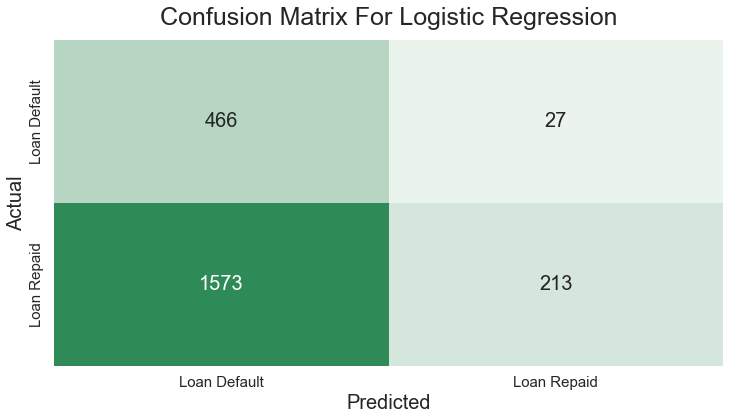

In [33]:
sns.set(rc = {'figure.figsize':(12,6)})
#cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
cmap = sns.light_palette('seagreen', as_cmap=True)

res = sns.heatmap(conf_mat, annot=True, fmt='d', annot_kws={"size":20},
#            xticklabels = ['Good = Paid In Full', 'Bad = Default'],
#            yticklabels = ['Loan Paid In Full', 'Bad = Default'], 
            cmap=cmap, cbar=False)

res.set_xticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)
res.set_yticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)


plt.title('Confusion Matrix For Logistic Regression', fontsize=25, pad=15)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20);

In [34]:
accuracy_score(y, y_pred_success)

0.29793769197016234

In [35]:
TN, FP, FN, TP = conf_mat.ravel()
print(TP)
print(FP)
print(FN)
print(TN)
print((TP + TN) / (TN + TP + FP + FN))

213
27
1573
466
0.29793769197016234


In [36]:
#Positive Predictive Value (or Precision)
#Logistic Model only does 3% better than Null Model or "random investment"
TP / (TP+FP)

0.8875

In [30]:
thresh = []
PosPredVal = []

for i in range(0,100,1):
    y_pred_success = (y_pred_prob[:, 1] > (i/100)).astype('float')
    conf_mat = confusion_matrix(y, y_pred_success)
    TN, FP, FN, TP = conf_mat.ravel()
    thresh.append(i)
    PosPredVal.append((TP/(TP+FP)))

print(np.max(PosPredVal))
print(PosPredVal.index(np.max(PosPredVal)))

0.8875
91


In [30]:
## Next question. what was characteristic of the 217 loans that defaulted??
## Get all loans which you predicted greater than 80% and find out which ones defaulted.
## Any pattern?????

In [31]:
#Do we drop all observations where the source is not verified? 
#Do we drop all observations loan amount is greater than half of one's income? 